# Market Basket Analysis: Descifrando la Identidad Gastronómica Global

**Autor:** Francisco Solís Pedraza
**Tipo de Proyecto:** Aprendizaje No Supervisado (Pattern Mining)
**Técnica:** Reglas de Asociación (Apriori Algorithm)

## 1. Contexto y Definición del Problema
¿Qué define la "identidad" de una cocina regional? Más allá de ingredientes aislados, son las **combinaciones** las que crean el sabor característico (ej: *Tomate + Albahaca* vs *Tomate + Chile*).

**Objetivo:**
Aplicar técnicas de minería de reglas de asociación para descubrir patrones de ingredientes latentes en recetas de diferentes regiones del mundo.

**Metodología:**
1.  **Preprocesamiento Transaccional:** Convertir recetas (listas de ingredientes) en una matriz binaria dispersa.
2.  **Algoritmo Apriori:** Minería de conjuntos de ítems frecuentes.
3.  **Métrica Lift:** Identificación de asociaciones fuertes que no son fruto del azar.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías específicas para Association Rules
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Configuración visual
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Ingesta y Transformación de Datos
Los algoritmos de asociación no trabajan con DataFrames estándar, requieren una estructura de **Matriz Transaccional** (One-Hot Encoded), donde cada columna es un ingrediente posible y cada fila una receta.

In [10]:
# Carga de datos
try:
    # El dataset original no tiene headers, asignamos nombres manuales
    data = pd.read_csv('../data/recetas.csv', sep=';', header=None, names=['Region', 'Ingredientes_Raw'])
    print(f"Total de Recetas cargadas: {data.shape[0]}")
except FileNotFoundError:
    print("Error: Verifica la ruta del archivo '../data/recetas.csv'")

# Visualización de la estructura cruda
data.head()

Total de Recetas cargadas: 56498


,Region,Ingredientes_Raw
0,African,"chicken,cinnamon,soy_sauce,onion,ginger"
1,African,"cane_molasses,ginger,cumin,garlic,tamarind,bre..."
2,African,"butter,pepper,onion,cardamom,cayenne,ginger,co..."
3,African,"olive_oil,pepper,wheat,beef,onion,cardamom,cum..."
4,African,"honey,wheat,yeast"


### 2.1 Preprocesamiento con TransactionEncoder
Convertimos la cadena de texto de ingredientes en una lista de Python y luego en la matriz booleana requerida.

In [11]:
# 1. Convertir string "ingrediente1,ingrediente2" -> Lista ['ingrediente1', 'ingrediente2']
recipes_list = data['Ingredientes_Raw'].apply(lambda x: x.split(',')).tolist()

# 2. Generar matriz transaccional
te = TransactionEncoder()
te_ary = te.fit(recipes_list).transform(recipes_list)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

# 3. Reintegrar la etiqueta de región para poder filtrar después
df_trans['Region'] = data['Region']

print(f"Dimensiones de la matriz transaccional: {df_trans.shape}")

num_ingredients = df_trans.iloc[0].drop('Region').astype(int).sum()
print(f"Ejemplo: La receta 0 tiene {num_ingredients} ingredientes.")

Dimensiones de la matriz transaccional: (56498, 382)
Ejemplo: La receta 0 tiene 5 ingredientes.


## 3. Minería de Reglas: Caso de Estudio "Latinoamérica"
Analizaremos específicamente la cocina **Latinoamericana** para encontrar las "reglas de oro" de su sabor. Usaremos el algoritmo **Apriori**.

In [12]:
def extract_rules(df, region_name, min_support=0.05, min_confidence=0.2):
    """
    Extrae reglas de asociación fuertes para una región específica.
    
    Parámetros:
    - min_support: Frecuencia mínima de aparición del conjunto de ítems.
    - min_confidence: Probabilidad de que Y ocurra dado X.
    """
    print(f"--- Analizando Región: {region_name} ---")
    
    # Filtrar solo recetas de la región y quitar la columna etiqueta
    subset = df[df['Region'] == region_name].drop(columns=['Region'])
    
    # 1. Encontrar Itemsets Frecuentes
    frequent_itemsets = apriori(subset, min_support=min_support, use_colnames=True)
    print(f"Itemsets frecuentes encontrados: {len(frequent_itemsets)}")
    
    # 2. Generar Reglas de Asociación
    # Usamos 'lift' > 1.2 para asegurar correlación positiva fuerte
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
    
    return rules.sort_values(by='lift', ascending=False)

# Ejecución del análisis
rules_latam = extract_rules(df_trans, 'LatinAmerican', min_support=0.05)

--- Analizando Región: LatinAmerican ---
Itemsets frecuentes encontrados: 759


### 3.1 Interpretación de Resultados
Analizamos las reglas con mayor **Lift**. El *Lift* indica cuánto más probable es encontrar el ingrediente B si ya compramos el A, comparado con la probabilidad de encontrar B por azar.

In [13]:
# Top 10 Reglas
print("Top 10 Reglas de la Cocina Latinoamericana:")
cols_show = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
print(rules_latam[cols_show].head(10))

Top 10 Reglas de la Cocina Latinoamericana:
                                     antecedents  \
8614       (oregano, garlic, onion, bell_pepper)   
8671               (tomato, black_pepper, cumin)   
8641       (garlic, tomato, black_pepper, cumin)   
8644               (oregano, onion, bell_pepper)   
7108               (oregano, onion, bell_pepper)   
7125               (tomato, black_pepper, cumin)   
8638        (onion, tomato, black_pepper, cumin)   
8647              (oregano, garlic, bell_pepper)   
8630  (garlic, onion, bell_pepper, black_pepper)   
8655                    (oregano, tomato, cumin)   

                                     consequents   support  confidence  \
8614               (tomato, black_pepper, cumin)  0.050394    0.683721   
8671       (oregano, garlic, onion, bell_pepper)  0.050394    0.644737   
8641               (oregano, onion, bell_pepper)  0.050394    0.653333   
8644       (garlic, tomato, black_pepper, cumin)  0.050394    0.665158   
7108         

## 4. Visualización de Patrones
Un gráfico de dispersión (Scatter Plot) nos permite visualizar la calidad de las reglas encontradas.
* **Eje X (Support):** Qué tan popular es la combinación.
* **Eje Y (Confidence):** Qué tan confiable es la regla.
* **Color/Tamaño (Lift):** La fuerza de la conexión.

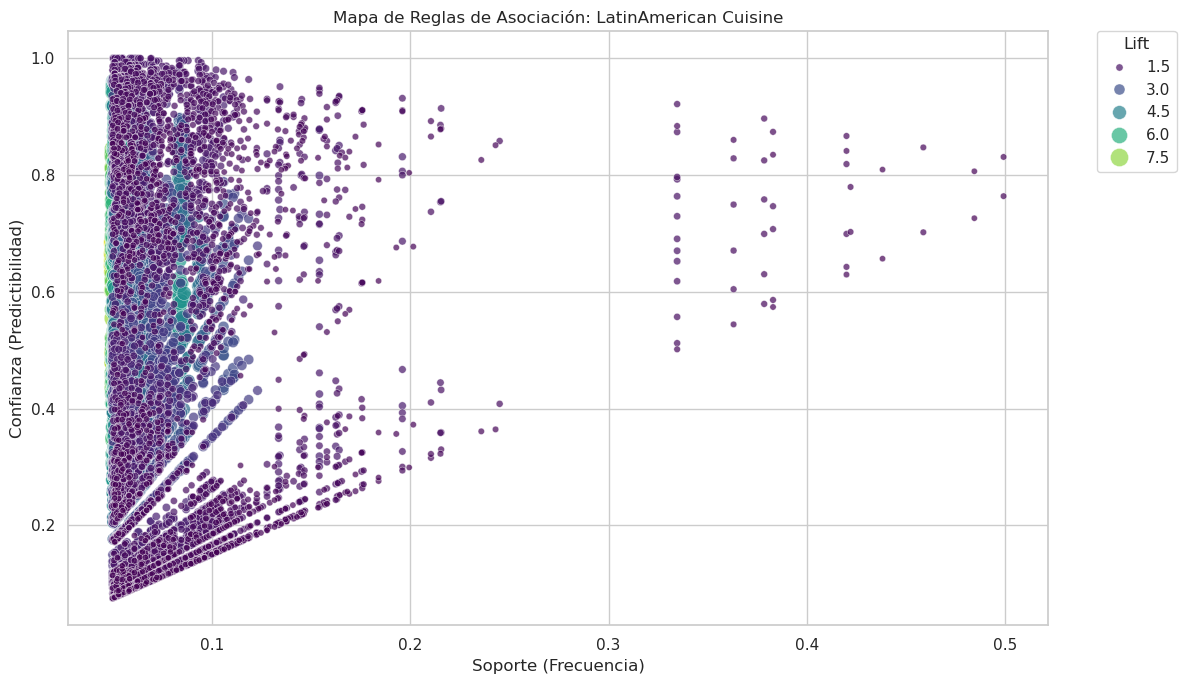

In [14]:
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=rules_latam, 
    x="support", 
    y="confidence", 
    size="lift", 
    hue="lift", 
    palette="viridis", 
    sizes=(20, 200),
    alpha=0.7
)
plt.title("Mapa de Reglas de Asociación: LatinAmerican Cuisine")
plt.xlabel("Soporte (Frecuencia)")
plt.ylabel("Confianza (Predictibilidad)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Lift")
plt.tight_layout()
plt.show()

## 5. Conclusiones de Negocio
1.  **Sistemas de Recomendación:** Las reglas con alta confianza (>0.8) son candidatas perfectas para motores de recomendación en e-commerce de alimentos ("Agregaste chiles, ¿quieres agregar tomates?").
2.  **Identidad Cultural:** Los ingredientes "puente" (con alto *betweenness* en las reglas) como la cebolla y el tomate en Latinoamérica, actúan como la base sobre la cual se construyen los sabores complejos.